# 개요
EuroSAT 데이터 세트[1]는 13 개의 스펙트럼 대역을 포함하는 Sentinel-2 위성 이미지를 기반으로하며 27000 개의 레이블이 지정되고 지리 참조 된 샘플이 포함 된 10 개의 클래스로 구성됩니다.

![image](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)

# 라이브러리 가져오기
모듈이란 함수나 변수 또는 클래스를 모아 놓은 파일입니다. 모듈은 다른 파이썬 프로그램에서 불러와 사용할 수 있게끔 만든 파이썬 파일이라고도 할 수 있습니다.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import pathlib 
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 데이터 로드
![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdVfds2%2FbtqLkhbs7T4%2FU97igLNa0nSfvmBPn5BnbK%2Fimg.png)
<center> [그림 1] </center>

In [4]:
splits=('train[:80%]','train[80%:90%]', 'train[90%:]')
(train, val, test),metadata=tfds.load(name='eurosat',
                                as_supervised=True,
                                split=splits,
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteE1045O/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [5]:
get_label_name=metadata.features['label'].int2str

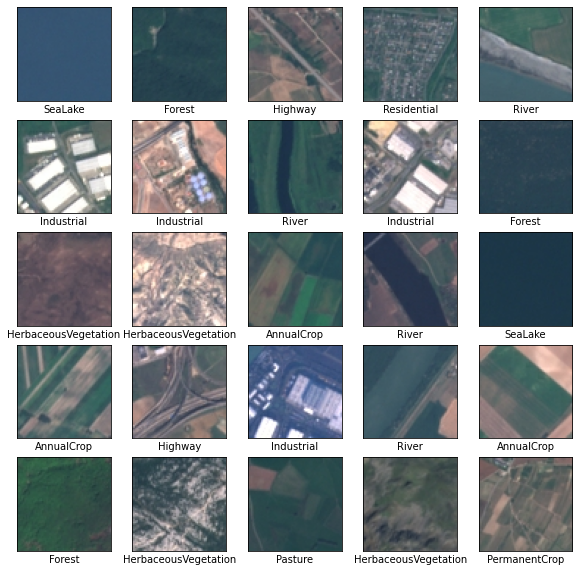

In [6]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in train.take(25):
    image = image.numpy().reshape((64,64,3))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    label = get_label_name(label.numpy())
    plt.xlabel(label)
    i += 1
plt.show()

# 하이퍼파라미터
하이퍼 파라미터는 모델을 학습할때 필요한 변수들을 사용자가 직접 설정해주는 값을 의미합니다. 하이퍼 파라미터는 정해진 최적의 값이 없기 때문에 경험에 의해 결정하는 경우가 많습니다. [2]

## 배치
배치(Batch)는 가중치를 한 번 업데이트하는 데 한 개 이상의 훈련 데이터를 사용하는 부분입니다. 그리고 이 집합에 포함하는 데이터의 양을 배치 크기라고 부릅니다. [3]

![image](http://t1.kakaocdn.net/braincloud/homepage/article_image/820bc25e-dd76-493d-a6a9-4f8d357dce90.png)

배치에 포함되는 데이터가 전체 훈련 데이터를 얼마나 잘 표현하느냐, 즉 오차를 제대로 된 방향으로 최소화(기울기)하는지에 따라 학습 안정성이 결정된다고 할 수 있습니다. 기울기가 실제 최적화 탐색 경로에서 크게 벗어나면 모델은 불안정적으로 데이터를 학습합니다. 반대로 기울기가 실제 최적화 탐색 경로와 비슷하면 모델은 안정적으로 데이터를 학습합니다. 

![image](http://t1.kakaocdn.net/braincloud/homepage/article_image/a3d23b87-eed1-4023-8b7a-31d2369c97b2.png)

하지만 배치 크기가 큰 상황에서는 모델 최적화와 일반화가 어렵습니다. 실제 학습이 극소값 또는 안장점 근처에서 진행되고 있다면 그래프상 점의 방향은 본래 구간을 벗어나 최소값이 존재하는 구간으로 옮겨져야 합니다. 하지만 앞서 설명한 대로 배치 크기가 큰 상황에서는 오차가 최소값이 아닌 극점에 빠져버린 상황을 벗어나기가 어렵습니다. 오차를 최소화하는 방향이 이미 정해졌을 확률이 크기 때문입니다. 이런 상황에서는 배치 크기가 작을수록 좋습니다. 특이값 데이터로 인해 실제와는 다른 방향의 기울기가 구해지면 가중치 값이 급격하게 변할 가능성이 커지기 때문입니다.

![image](http://t1.kakaocdn.net/braincloud/homepage/article_image/8d9f428e-2bc2-4b74-8c97-709eed44cb44.png)

일반화가 어렵다는 건 학습 데이터와 조금이라도 다른 성격의 데이터를 입력받으면 모델이 제대로 동작하지 않을 가능성이 높은 상황을 가리킵니다. 한 연구 논문은 큰 배치 크기로 훈련한 모델을 입력받은 손실 함수의 값(오차)이 그래프 내 경사가 상대적으로 급격하게 변하는 구간의 최소값(sharp minimum)으로 수렴한다는 사실을 실험적으로 확인했습니다. 이렇게 되면 테스트 시 오차는 입력 데이터에 따라 매우 큰 폭으로 변하게 됩니다.

![image](http://t1.kakaocdn.net/braincloud/homepage/article_image/57a5abec-5c1d-494c-97b6-8b81a0b7f361.png)  

따라서 적절한 배치 크기 탐색은 모델 훈련에서 매우 중요한 과업 중 하나라고 볼 수 있습니다(mini-batch gradient descent, MGD). 보통 연구 초반에는 기준 모델(baseline model)이나 해당 연구 도메인에서 자주 사용하는 배치 크기를 기준으로 다양한 실험을 통해 최적의 값을 탐색합니다. 



## 이미지 해상도
![image](https://pubs.rsna.org/cms/10.1148/ryai.2019190015/asset/images/medium/ryai.2019190015.fig1.gif)
<center> [그림 2] </center>

In [7]:
batch_size = 32
epochs = 5
img_height = 64
img_width = 64

# 데이터 증강
데이터 증강(Data Augmentation)은 새로운 데이터를 실제로 수집하지 않고도 모델이 사용할 수 있는 데이터의 다양성을 높이는 방법입니다. [4]

![image](https://hoya012.github.io/assets/img/Augmentation/2.PNG)
<center> [그림 3] </center>

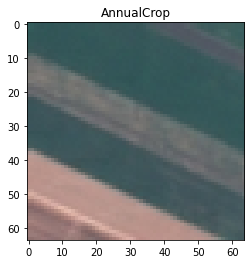

In [8]:
image, label = next(iter(val))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [9]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

이미지를 수직 또는 수평으로 뒤집습니다.

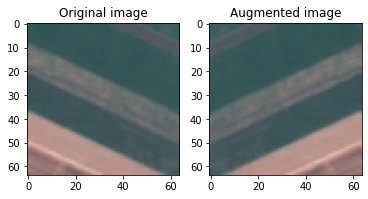

In [10]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

이미지를 회색조로 만듭니다.

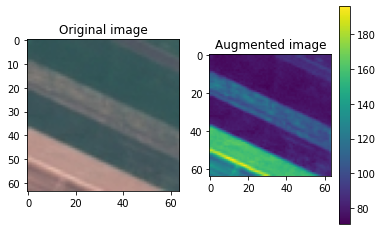

In [11]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

이미지의 밝기를 조절합니다.

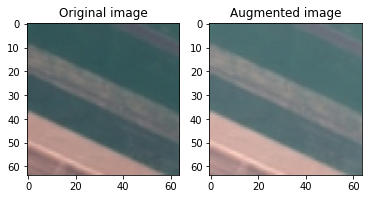

In [12]:
bright = tf.image.adjust_brightness(image, 0.1)
visualize(image, bright)

이미지를 중앙에서 원하는 부분까지 자릅니다.

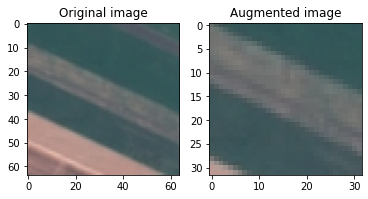

In [13]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

이미지를 90도 회전합니다.

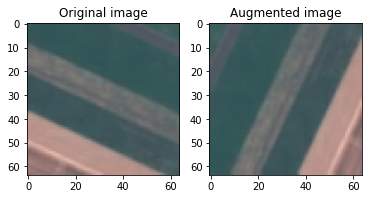

In [14]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [15]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])
  image = (image / 255.0)
  return image, label

In [16]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  image = tf.image.rot90(image)
  image = tf.image.random_crop(image, size=[img_height, img_width, 3]) # Random crop back to the original size
  return image, label

# 데이터 세트 구성하기

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
train = (
    train
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [19]:
val = (
    val
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [20]:
test = (
    test
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# 모델

**Convolution Neural Network**  
CNN에는 피쳐 추출을 위한 Convolution 모듈(Convolution + ReLU + pooling)과 분류를 위한 Fully connected layer가 있습니다. [5]
![image](https://developers.google.com/machine-learning/practica/image-classification/images/cnn_architecture.svg?hl=ko-KR)

## Layer - Convolution
컨볼루션 피쳐 맵의 타일을 추출하고 여기에 필터를 적용하여 새로운 피쳐를 계산한다. 

컨볼루션은 다음 두 가지 매개변수로 정의됩니다.
* 타일의 크기
* 출력 피쳐 맵의 크기

변환하는 동안 필터(타일 크기와 동일한 크기의 매트릭스)는 입력 피처 맵의 그리드 위로 한 번에 한 픽셀씩 수평 및 수직으로 이동하면서 각 해당 타일을 추출합니다.

![image](https://developers.google.com/machine-learning/practica/image-classification/images/convolution_overview.gif?hl=ko-KR)

깊이 1의 3x3 변환은 깊이 1의 5x5 입력 피쳐 맵을 통해 수행됩니다. 5x5 피쳐 맵에서 타일을 추출할 수 있는 9개의 3x3 위치가 있으므로, 이 컨볼루션은 3x3 출력 피쳐 맵을 생성합니다.

각 필터-타일 쌍에 대해 CNN은 필터 행렬과 타일 행렬의 요소별 곱셈을 수행한 다음 결과 행렬의 모든 요소를 합산하여 단일 값을 가져옵니다. 그런 다음 모든 필터-타일 쌍에 대한 각 결과 값이 컨버전스 피쳐 매트릭스로 출력됩니다.

![image](https://developers.google.com/machine-learning/practica/image-classification/images/convolution_example.svg?hl=ko-KR)
![image](https://drive.google.com/uc?export=view&id=1Zt07SKhOrSfrXQywwwFNG71pgkQ9689i)

모델을 훈련하는 중에 CNN은 입력 피쳐 맵에서 의미 있는 피쳐(질감, 모서리, 모양)를 추출 할 수 있는 필터 매트릭스의 최적 값을 학습합니다. 입력에 적용되는 필터 수(출력 피쳐 맵 깊이)가 증가함에 따라 CNN이 추출할 수 있는 기능의 수도 증가합니다. 그러나 필터가 CNN이 지출한 자원의 대부분을 차지하기 때문에 필터가 추가될수록 훈련 시간도 늘어난다는 단점이 있습니다.

![image](https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif)
<center> [그림 4] </center>

## Layer - ReLU (Activation Function)
활성 함수(Activation Function)은 입력 신호의 총합을 출력신호로 변환하는 함수입니다. 활성화(Activate)라는 이름에서 알 수 있듯이 활성화 함수란 입력 신호의 총합이 활성화를 일으키는지 정하는 역활을 합니다. [6]

신경망에서는 뉴런(노드)에 연산 값을 계속 전달해주는 방식으로 가중치를 훈련하고, 예측을 진행합니다.

각각의 함수는 네트워크의 각 뉴런에 연결되어 있으며, 각 뉴련의 입력이 모델의 예측과 관련되어 있는지 여부에 따라 활성화 됩니다. 이런 활성화를 통해 신경망은 입력값에서 필요한 정보를 학습합니다. 

![image](https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png) 

ReLU(Rectified Linear Unit)는 내부 hidden layer를 활성화 시키는 함수로 0보다 작은 값이 나온 경우 0을 반환하고, 0보다 큰 값이 나온 경우 그 값을 그대로 반환 하는 함수입니다.

![image](https://mblogthumb-phinf.pstatic.net/MjAyMDAyMjVfMTQ3/MDAxNTgyNjA5NDY3MTY3.228bUv_5mrol1w7X0NiFMD1UNru9zyf3yIJGcON-An0g.3Kzynlja9y_F9yTfANl937elQAK1pTGoJ_al7Om7TYsg.PNG.handuelly/image.png?type=w800)
<center> [그림 5] </center>

## Layer - Pooling
ReLU가 실행된 후, CNN이 처리 시간을 줄이기 위해서 피쳐 맵의 차원을 줄이면서 가장 중요한 피쳐 정보를 보존하는 방법이 풀링이며 일반적으로 Max Pooling이 사용된다.  

![image](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif?hl=ko-KR)

맥스 풀링(Max Pooling)은 컨볼루션과 유사한 방식으로 작동합니다. 피쳐 맵 위로 슬라이드하여 지정된 크기의 타일을 추출하고 각 타일에 대해 최대값이 새 피쳐 맵으로 출력되고 다른 모든 값이 삭제됩니다. 맥스 풀링 작업에는 두 가지 매개 변수가 사용됩니다. 
* 필터의 크기 
* 보폭(stride): 추출된 각 타일을 구분하는 거리로 필터를 픽셀 단위로 피쳐 맵 위로 이동하는 컨볼루션과 달리 최대 풀링에서 보폭은 각 타일이 추출되는 위치를 결정합니다. 2x2 필터의 경우 최대 풀링 작업이 피쳐 맵에서 겹치지 않는 2x2 타일을 모두 추출하도록 2의 보폭을 지정합니다.



## Layer - Fully Connect Layers
Fully connected layer는 '완전 연결 되었다'라는 뜻으로 한 층(layer)의 모든 뉴런이 그 다음 층(layer)의 모든 뉴런과 연결된 상태를 말합니다. 1차원 배열의 형태로 평탄화된 행렬을 통해 이미지를 분류하는데 사용되는 계층입니다. [7]

![image](https://cdn-images-1.medium.com/max/600/1*yjy3dwRL-vmSpmUG7UNJYg@2x.png)
<center> [그림 6] </center>

In [25]:
num_classes = 10

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [26]:
model.build((None, 64, 64, 3))                 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 128)       

# Compile

## Optimizer

옵티마이저(Optimizer)는 트레이닝 중에 모델의 가충치를 조정하여서 예측을 최대한 정확하고 최적화시키는 방법입니다. 옵티마이저는 손실 함수(loss function)의 값에 따라서 모델과 손실함수를 업데이트를 합니다. 손실 함수는 올바른 방향으로 또는 잘못된 방향으로 이동할 때 옵티마이저에게 알려주는 안내 기능입니다. [8]
![image](https://ml-cheatsheet.readthedocs.io/en/latest/_images/optimizers.gif)

## loss function(cost function)
손실 함수는 지도 학습에서 사용되는 방법으로, 실제 결과와 비교하여 예측된 결과 사이의 차이를 반환합니다.
![image](https://miro.medium.com/max/1400/0*M0-6vU-TYBwjluLN.png)
<center> [그림 9] </center>

## Metrics
메트릭스는 성능을 평가하는 데 사용되는 함수입니다.


In [27]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [28]:
log_dir = "logs" + datetime.datetime.now().strftime("/%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
history = model.fit(
    train,
    batch_size=batch_size,
    validation_data=val,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
675/675 [==============================] - 22s 21ms/step - loss: 1.2398 - accuracy: 0.5228 - val_loss: 1.2743 - val_accuracy: 0.5504
Epoch 2/5
675/675 [==============================] - 14s 20ms/step - loss: 0.7710 - accuracy: 0.7167 - val_loss: 0.8055 - val_accuracy: 0.7033
Epoch 3/5
675/675 [==============================] - 14s 21ms/step - loss: 0.6285 - accuracy: 0.7718 - val_loss: 0.6518 - val_accuracy: 0.7619
Epoch 4/5
675/675 [==============================] - 14s 20ms/step - loss: 0.5395 - accuracy: 0.8054 - val_loss: 0.7100 - val_accuracy: 0.7500
Epoch 5/5
675/675 [==============================] - 14s 20ms/step - loss: 0.4767 - accuracy: 0.8276 - val_loss: 0.5527 - val_accuracy: 0.7981


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
model.evaluate(test)

85/85 [==============================] - 1s 13ms/step - loss: 0.7021 - accuracy: 0.7619


[0.7020878195762634, 0.7618518471717834]

In [ ]:
for test_images, test_labels in test.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(get_label_name(predicted_label),
                                100*np.max(predictions_array),
                                get_label_name(true_label)),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

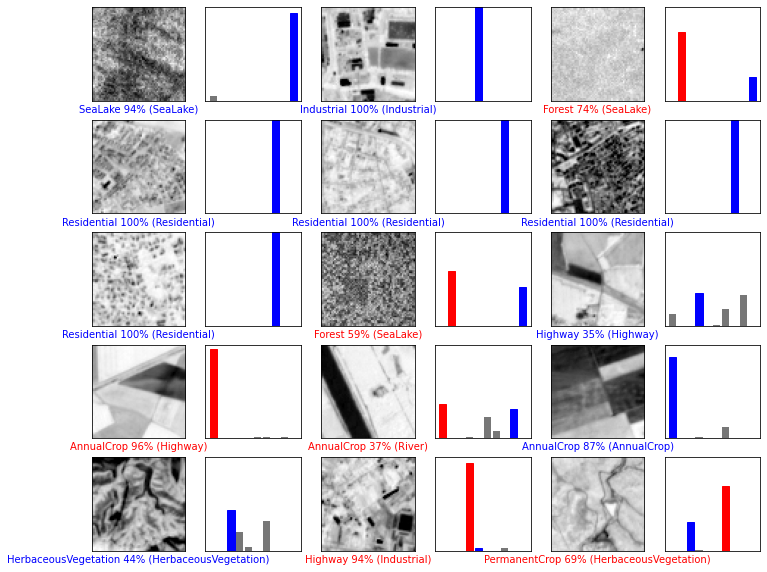

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

# Reference  

[1]https://github.com/phelber/EuroSAT  

[2]https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-13-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0Parameter%EC%99%80-%ED%95%98%EC%9D%B4%ED%8D%BC-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0Hyper-parameter 

[3]https://www.kakaobrain.com/blog/113  

[4]https://hoya012.github.io/blog/Image-Data-Augmentation-Overview/  

[5]https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks  

[6]https://subinium.github.io/introduction-to-activation/

[7]https://dsbook.tistory.com/59

[8]https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html

[그림 1]https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdVfds2%2FbtqLkhbs7T4%2FU97igLNa0nSfvmBPn5BnbK%2Fimg.png

[그림 2]https://pubs.rsna.org/cms/10.1148/ryai.2019190015/asset/images/medium/ryai.2019190015.fig1.gif

[그림 3]https://hoya012.github.io/assets/img/Augmentation/2.PNG

[그림 4]https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif

[그림 5]https://mblogthumb-phinf.pstatic.net/MjAyMDAyMjVfMTQ3/MDAxNTgyNjA5NDY3MTY3.228bUv_5mrol1w7X0NiFMD1UNru9zyf3yIJGcON-An0g.3Kzynlja9y_F9yTfANl937elQAK1pTGoJ_al7Om7TYsg.PNG.handuelly/image.png?type=w800

[그림 6]https://cdn-images-1.medium.com/max/600/1*yjy3dwRL-vmSpmUG7UNJYg@2x.png

[그림 7]https://miro.medium.com/max/1400/0*M0-6vU-TYBwjluLN.png